# Reading the data

In [2]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dataPath = "../data/"

In [3]:
# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [4]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

Protein names equality check: True


In [5]:
print receptor_names

['NR-AhR' 'NR-AR-LBD' 'NR-AR' 'SR-MMP' 'NR-ER' 'SR-HSE' 'SR-p53'
 'NR-PPAR-gamma' 'SR-ARE' 'NR-Aromatase' 'SR-ATAD5' 'NR-ER-LBD']


# Training classifiers and printing results

In [6]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKF
import sklearn

In [7]:
def getXY(classToTrain, X, Y, badValue = 999):
    """
    Get objects and answers for class classToTrain
    for which answers are available
    """
    
    haveAnswersObjectsIndices = np.where(Y[:, classToTrain] != badValue)
    classX = X[haveAnswersObjectsIndices, :][0]
    classY = Y[haveAnswersObjectsIndices, classToTrain][0]
    return classX, classY

In [8]:
def showROCCurve(fpr, tpr, auc_mean, auc_std, filename):
    """
    Plot a ROC curve from fpr, tpr
    """
    
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    params = {'text.usetex' : True,
          'font.size' : 15,
#          'font.family' : 'lmodern',
          'text.latex.unicode': True}
    plt.rcParams.update(params) 
    plt.plot(fpr, tpr, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.tick_params(axis='both', which='major')
    auc_mean = '%.2g' % auc_mean
    auc_std = '%.1g' % auc_std
    plt.title(r"AUC $= %s\,\pm\,%s$" % (auc_mean, auc_std), fontsize=15)
    plt.savefig(filename + ".eps", bbox_inches = 'tight')
    plt.show()

In [9]:
def getROCCurve(XTrain, XTest, YTrain, YTest):
    """
    Train classifier and return fpr, tpr
    """
    
    # Learn to predict the class
    classifier = LR()
    classifier.fit(XTrain, YTrain)

    # get predicted probabilities for class
    YScore = classifier.predict_proba(XTest)[:, 1]

    # calculate fpr and tpr
    fpr, tpr, _ = roc_curve(YTest, YScore)
    return(fpr, tpr)

In [10]:
def showClass(currentClass, X, Y, folds):
    """
    Split data, train classifiers, get AUC Array, show chart
    """
    # get objects and answers with existing answers
    XClass, YClass = getXY(currentClass, X, Y)

    # get folds-fold cross validation split indices
    IFolds = SKF(YClass, folds)
    
    roc_auc = list()
    for ITrain, ITest in IFolds:
        # get train & test data
        XTrain, YTrain = XClass[ITrain], YClass[ITrain]
        XTest,  YTest  = XClass[ITest],  YClass[ITest]
        
        # train classifier
        # get FPR, TPR
        fpr, tpr = getROCCurve(XTrain, XTest, YTrain, YTest)
        
        # get AUC value
        roc_auc.append(auc(fpr, tpr))
        
    showROCCurve(fpr, tpr, np.mean(roc_auc), np.std(roc_auc), "class%d" % (currentClass + 1))

In [ ]:
folds = 5
for currentClass in range(Y.shape[1]):
    showClass(currentClass, X, Y, folds)

In [ ]:
def printClassStatistics(currentClass, X, Y):
    ans_1 = len(np.where(Y[:, currentClass] == 1)[0])
    ans_0 = len(np.where(Y[:, currentClass] == 0)[0])
    ans_none = len(np.where(Y[:, currentClass] == 999)[0])
    total = Y.shape[0]
    
    #print("Class %d TOTAL=%d ONES=%d (%.2g %%) ZEROS=%d (%.2g %%) KNOWN=%d (%.2g %%)" % (currentClass + 1,
    #                                                                                     total, ans_1, 100. * ans_1 / total,
    #                                                                                     ans_0, 100. * ans_0 / total,
    #                                                                                     ans_0 + ans_1,
    #                                                                                     100. * (ans_0 + ans_1) / total))
    texStr="{\\tt %s}\n& $\mathbf{%d}\, (%d \%%)$\n& $\mathbf{%d}\, (%d \%%)$\n& $\mathbf{%d}\, (%d \%%)$\\\\\n"
    print(texStr % (receptor_names[currentClass], ans_none, 100 * ans_none / total,
                    ans_0, 100 * ans_0 / total,
                   ans_1, 100 * ans_1 / total))

In [ ]:
for currentClass in range(Y.shape[1]):
    printClassStatistics(currentClass, X, Y)

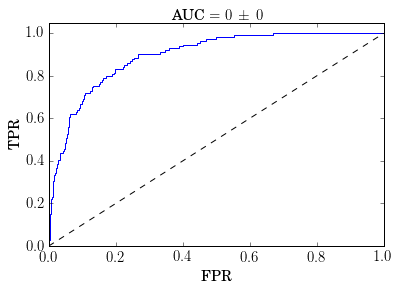

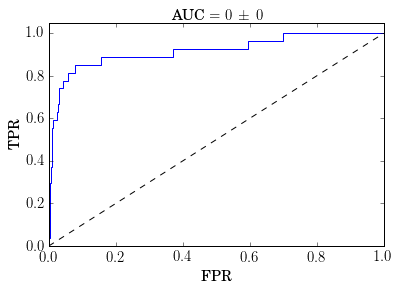

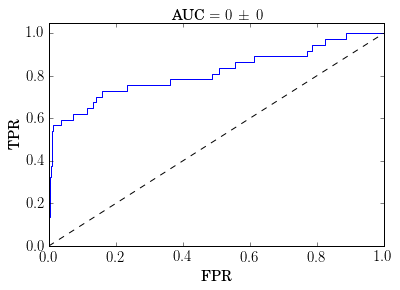

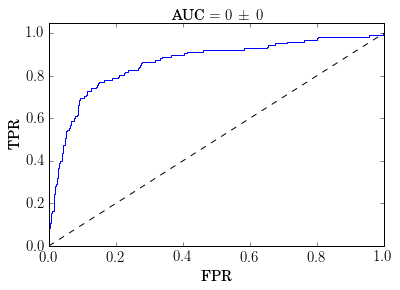

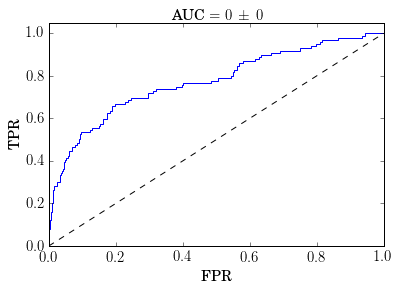

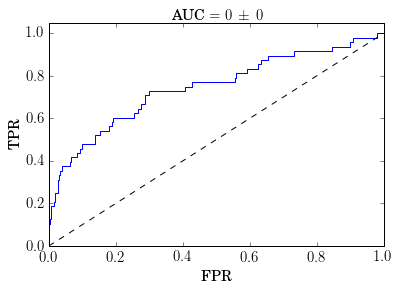

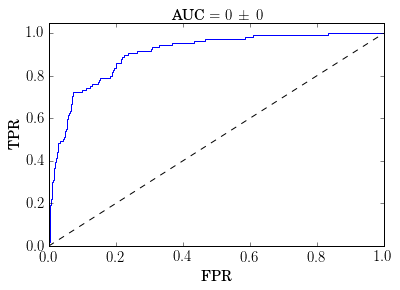

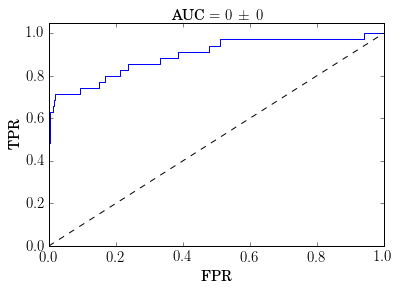

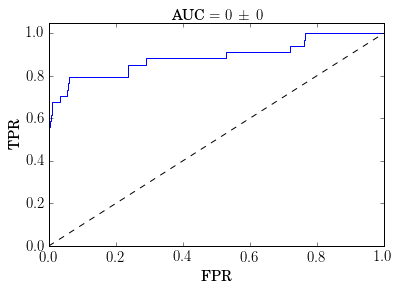

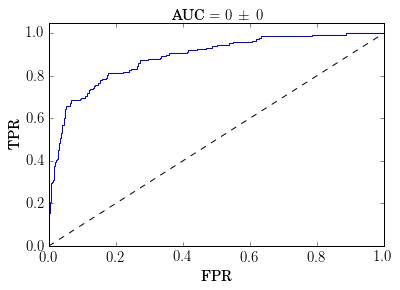

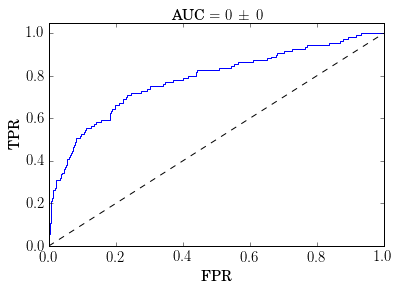

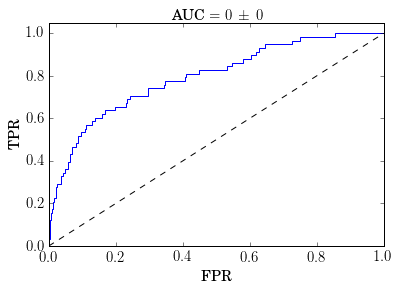

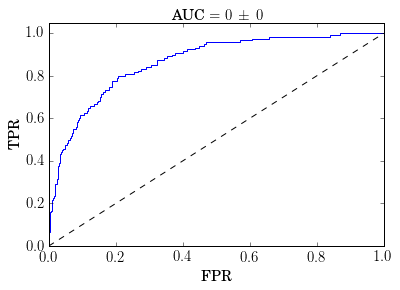

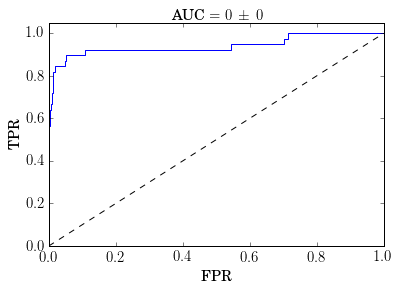

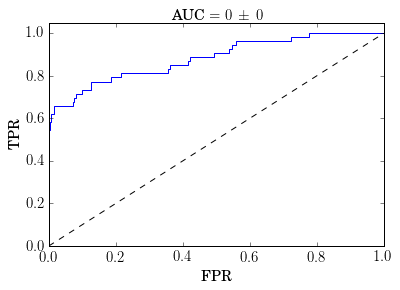

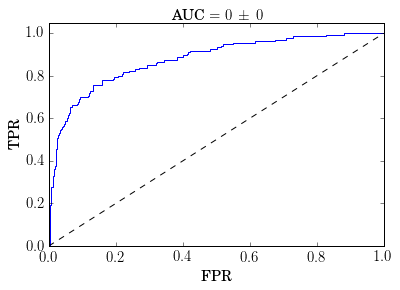

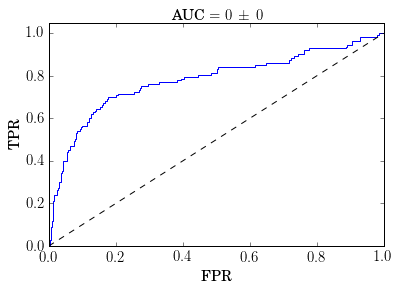

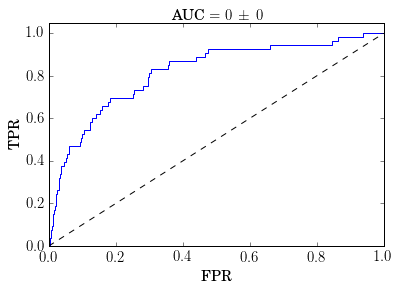

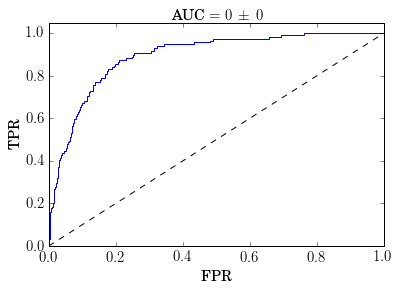

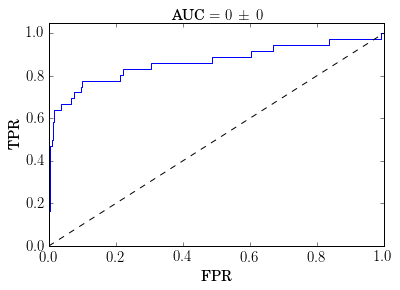

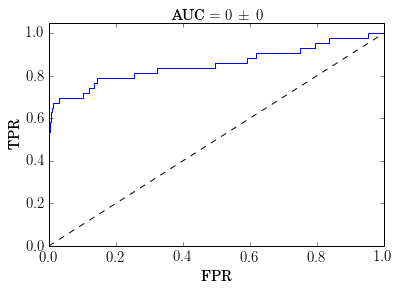

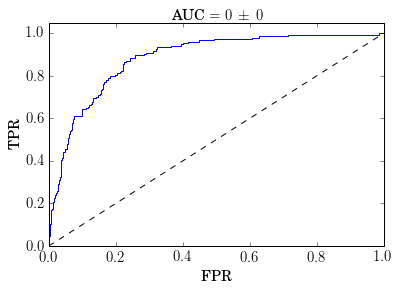

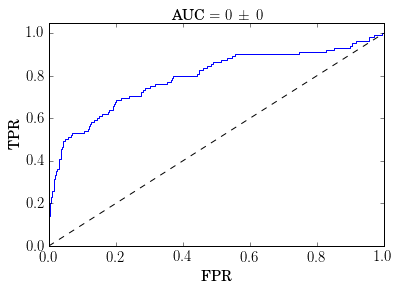

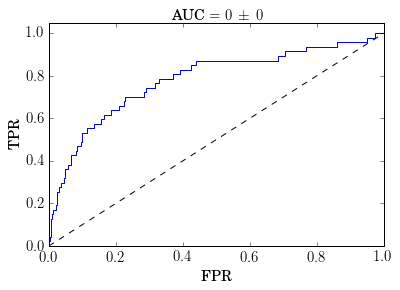

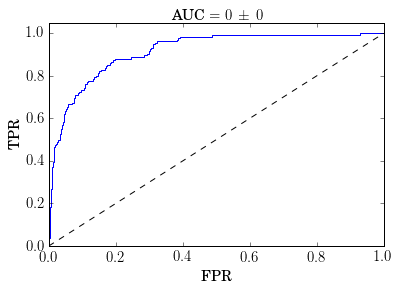

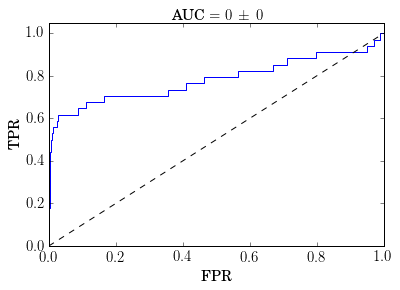

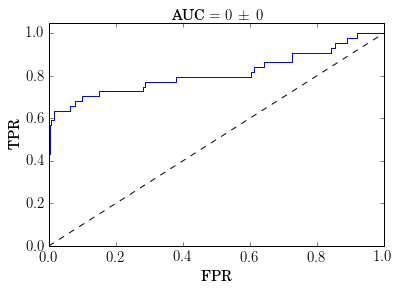

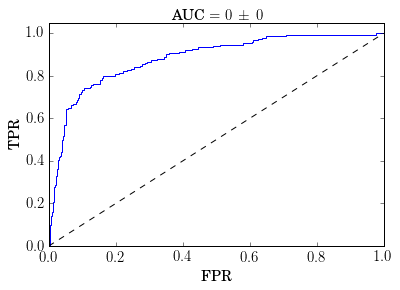

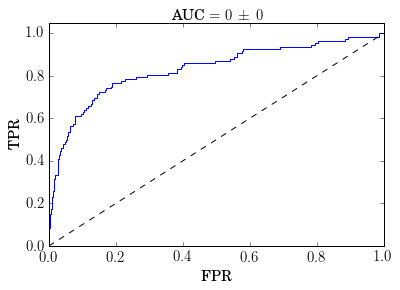

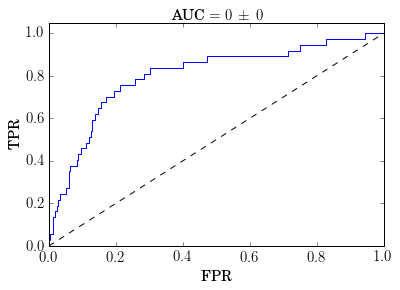

Class 1 AUC 0.896741 +- 0.016886
Class 2 AUC 0.881099 +- 0.054986
Class 3 AUC 0.851324 +- 0.031751
Class 4 AUC 0.879905 +- 0.008615
Class 5 AUC 0.793630 +- 0.020526
Class 6 AUC 0.789496 +- 0.024034


In [11]:
folds = 5
IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                               random_state=32)
#IFolds = SKF(Y, folds)
maxC = 6

roc_auc = np.zeros((folds, maxC))
fold = 0
for ITrain, ITest in IFolds:
    # get train & test data
    XTrain, YTrain = X[ITrain], Y[ITrain]
    XTest,  YTest  = X[ITest],  Y[ITest]
    
    for i in range(maxC):
        XTrainc, YTrainc = getXY(i, XTrain, YTrain)
        XTestc, YTestc = getXY(i, XTest, YTest)
        
        C = LR(fit_intercept = False)
        C.fit(XTrainc, YTrainc)
        
        YTestS = C.decision_function(XTestc)

        fpr, tpr, _ = roc_curve(YTestc, YTestS)
        showROCCurve(fpr, tpr, 0, 0, "")
        roc_auc[fold][i] = auc(fpr, tpr)
    fold += 1
       
for i in range(maxC):
    auc_mean = np.mean(roc_auc[:, i])
    auc_std = np.std(roc_auc[:, i])
    print("Class %d AUC %f +- %f" % (i + 1, auc_mean, auc_std))

In [30]:
print("%.2g"% (0.127))

0.13
